In [1]:
import cupy as cp
from dataset import load_mnist
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
cp.cuda.Device(0).use()

In [3]:
train_data, test_data, train_label, test_label = load_mnist()

train_data = train_data.reshape(-1, 1, 28, 28)
test_data = test_data.reshape(-1, 1, 28, 28)

train_data, valid_data, train_label, valid_label = train_test_split(train_data, train_label, test_size=0.2)

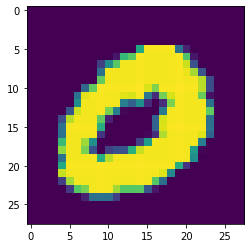

0

In [4]:
plt.imshow(valid_data[6].reshape(28, 28))
plt.show()
valid_label[6]

In [5]:
def label_to_one_hot(y, n_class):
    one_hot = cp.zeros((y.shape[0], n_class))
    for i in range(len(y)):
        one_hot[i][int(y[i])] = 1
    
    return one_hot

In [6]:
class Linear:
    def __init__(self, input_dim, output_dim):
        self.params = {}
        self.params['W'] = cp.random.randn(input_dim, output_dim) / cp.sqrt(input_dim)
        self.params['b'] = cp.random.randn(output_dim)
        
        self.grads = {}
        
    def forward(self, x):
        
        self.x = x
        
        out = cp.dot(x, self.params['W']) + self.params['b']    
        return out
    
    def backward(self, dout):
        
        self.grads['W'] = cp.dot(self.x.T, dout)
        self.grads['b'] = cp.sum(dout, axis=0)
        
        return cp.dot(dout, self.params['W'].T)

In [7]:
class ReLU:
    def __init__(self):
        self.params = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        
        return dout

In [8]:
class SoftmaxWithCrossEntropyLoss:
    def __init__(self):
        self.params = None
    
    def forward(self, out, y):
        '''
            out: output of last fully connected layer
            y: true label
        '''
        
        batch_size = out.shape[0]
        
        max_val = cp.max(out, axis=1).reshape(-1, 1)
        exp_out = cp.exp(out - max_val)
        sum_exp_out = cp.sum(exp_out, axis=1).reshape(-1, 1)
        out = exp_out / sum_exp_out
        
        self.out = out
        self.y = y
        
        log_out = cp.log(out + 1e-7)
    
        loss = cp.sum(-log_out * y)
            
        return loss / batch_size, out
    
    def backward(self, dout):
        return (self.out - self.y) / batch_size

In [9]:
class Conv2d:
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        '''
            kernel size is a tuple: (height, width)
            
            out_channels: it is equal to number of filters
            
            in_channels: number of matrix in each filter
            
            padding: is omitted
        '''
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        
        '''
            padding it is omitted
        '''
        self.padding = 0
        
        self.params = {}
        
        self.params['W'] = cp.random.randn(out_channels, in_channels, kernel_size[0], kernel_size[1])
        
        self.params['b'] = cp.random.randn(out_channels)
        
        self.grads = {}
        
    def forward(self, x):
        '''
            x: (batch_size, in_channels, height, width)
        '''
        
        self.x_shape = x.shape
        
        self.batch_size, in_channels, in_h, in_w = x.shape
        
        out_h = 1 + int((in_h + 2*self.padding - self.kernel_size[0]) / self.stride)
        out_w = 1 + int((in_w + 2*self.padding - self.kernel_size[1]) / self.stride)
        
        self.out_h, self.out_w = out_h, out_w
        self.in_h, self.in_w = in_h, in_w
        
        im2col_x = []
        
        for b in range(self.batch_size):
            for i in range(out_h):
                for j in range(out_w):
                    h_start = i * self.stride
                    h_end = h_start + self.kernel_size[0]
                    w_start = j * self.stride
                    w_end = w_start + self.kernel_size[1]

                    current_region = x[b, :, h_start:h_end, w_start:w_end]

                    current_region = current_region.reshape(1, -1)

                    im2col_x.append(current_region)
        
        im2col_x = cp.array(im2col_x)

        im2col_x = im2col_x.squeeze(1)

        
        self.im2col_x = im2col_x
        self.W = self.params['W'].reshape(self.out_channels, -1).T
        
        out = cp.dot(im2col_x, self.W)
        
        out = out + self.params['b']

        # this line
        self.out_shape = out.shape
        
        _out = []
        for b in range(self.batch_size):
            
            row_start = out_h * out_w * b
            row_end = out_h * out_w * (b + 1)
            
            _out_b = []
            
            for oc in range(self.out_channels):
                region = out[row_start:row_end, oc].reshape(out_h, out_w)
                
                _out_b.append(region)
            _out.append(_out_b)
        
        _out = cp.array(_out)
        
        return _out
        
    def backward(self, dout):
        
        self.grads['b'] = cp.sum(cp.sum(dout, axis=(-1, -2)), axis=0).reshape(self.out_channels)

        '''
            shape of grads: (batch_size, out_h, out_w, out_channels)
        '''
        grads = dout.transpose(0, 2, 3, 1).reshape(self.out_shape)
        
        self.grads['W'] = cp.dot(self.im2col_x.T, grads)
        
        self.grads['W'] = self.grads['W'].T.reshape(self.params['W'].shape)
        
        self.dout = cp.dot(grads, self.W.T)
        
        self.grads_x = cp.zeros(self.x_shape)
        
        self.dout = self.dout.reshape(self.dout.shape[0], self.in_channels, int(self.dout.shape[1] / self.in_channels))
        
        self.dout = self.dout.reshape(self.batch_size, self.out_h, self.out_w, 
                                      self.in_channels, self.kernel_size[0], self.kernel_size[1])

        for h in range(self.out_h):
            h_start = h * self.stride
            h_end = h_start + self.kernel_size[0]
            for w in range(self.out_w):
                w_start = w * self.stride
                w_end = w_start + self.kernel_size[1]
                
                self.grads_x[:, :, h_start:h_end, w_start:w_end] += self.dout[:, h, w]
                
        return self.grads_x

In [10]:
c = Conv2d(2, 2, (2, 2), 1)

x = cp.random.randn(1, 2, 3, 3)

out = c.forward(x)

c.backward(out)

array([[[[ -0.72043991,  -3.31373979,  -8.42731572],
         [  7.27480558,  15.57900214,   1.85605171],
         [ -1.10265072,  -8.67050987,   1.37808621]],

        [[  0.20853502,   2.3436287 ,   2.90548026],
         [ -6.93055036,   0.28773803,   1.46510664],
         [-12.06518582,   3.32938683,   1.71117612]]]])

In [11]:
class MaxPool2d:
    def __init__(self, kernel_size, stride):
        
        '''
            kernel size is a tuple: (height, width)
        '''
        
        self.kernel_size = kernel_size
        self.stride = stride
        
        self.params = None
    
    def forward(self, x):
        
        batch_size, in_channels, in_h, in_w = x.shape
        
        self.batch_size = batch_size
        
        self.in_channels = in_channels
        
        out_h = int(1 + (in_h - self.kernel_size[0]) / self.stride)
        out_w = int(1 + (in_w - self.kernel_size[1]) / self.stride)
        
        self.out_h, self.out_w = out_h, out_w
        
        im2col_x = []
        
        for i in range(in_channels):
            for j in range(out_h):
                for k in range(out_w):
                    h_start = j * self.stride
                    h_end = h_start + self.kernel_size[0]
                    w_start = k * self.stride
                    w_end = w_start + self.kernel_size[1]
                    
                    current_region = x[:, i, h_start:h_end, w_start:w_end]
                    
                    current_region = current_region.reshape(batch_size, -1)
                    
                    im2col_x.append(current_region)
                    
        im2col_x = cp.array(im2col_x)
        
        im2col_x = im2col_x.transpose(1, 0, 2)

        self.x_shape = x.shape
        self.im2col_x_shape = im2col_x.shape
        
        out = cp.max(im2col_x, axis=2)
        
        self.arg_max = cp.argmax(im2col_x, axis=2)
        
        out = out.reshape(batch_size, in_channels, out_h, out_w)

        return out
        
    def backward(self, dout):
    
        self.dout = cp.zeros(self.x_shape)
            
        dout = dout.reshape(self.batch_size, -1)
            
        for b in range(self.batch_size):
                
            index = 0
                
            for i in range(self.in_channels):
                for j in range(self.out_h):
                    for k in range(self.out_w):
                        h_start = j * self.stride                
                        w_start = k * self.stride

                        p = h_start + int(self.arg_max[b][index] /  self.kernel_size[0])
                        q = w_start + self.arg_max[b][index] % self.kernel_size[1]

                        self.dout[b, i, p, q] += dout[b, index]

                        index += 1
            
        return self.dout

In [12]:
m = MaxPool2d((2, 2), 1)

x = cp.random.randn(3, 2, 3, 3)

out = m.forward(x)

m.backward(out)

array([[[[0.        , 0.60906548, 0.        ],
         [1.80856837, 0.        , 0.        ],
         [0.        , 0.        , 1.37122347]],

        [[0.        , 0.        , 0.        ],
         [0.        , 1.34386209, 0.        ],
         [0.        , 1.60921718, 0.        ]]],


       [[[0.        , 0.        , 0.        ],
         [1.6215562 , 0.        , 2.52840667],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [2.00241194, 0.        , 4.66574918],
         [0.        , 0.        , 0.        ]]],


       [[[0.        , 0.        , 0.        ],
         [0.        , 2.28393851, 0.        ],
         [0.89565669, 0.        , 0.        ]],

        [[0.        , 2.71360916, 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 2.18691032, 0.        ]]]])

In [13]:
class FNN:
    def __init__(self):
        self.layers = []
        self.layers.append(Linear(784, 400))
        self.layers.append(ReLU())
        self.layers.append(Linear(400, 200))
        self.layers.append(ReLU())
        self.layers.append(Linear(200, 100))
        self.layers.append(ReLU())
        self.layers.append(Linear(100, 10))
        self.layers.append(SoftmaxWithCrossEntropyLoss())

        
    def forward(self, x, y):
        batch_size = x.shape[0]
        
        y = label_to_one_hot(y, 10)
        
        x = x.reshape(batch_size, 784)
        
        for layer in self.layers[:-1]:
            x = layer.forward(x)
        
        return self.layers[-1].forward(x, y)
    
    
    def backward(self):
        dout = 1
        for layer in self.layers[::-1]:
            dout = layer.backward(dout) 

In [14]:
class CNN:
    def __init__(self):
        self.layers = []
        self.layers.append(Conv2d(in_channels=1, out_channels=3, kernel_size=(3, 3), stride=2))
        self.layers.append(ReLU())
        self.layers.append(MaxPool2d(kernel_size=(2, 2), stride=1))
        self.layers.append(Conv2d(in_channels=3, out_channels=6, kernel_size=(3, 3), stride=1))
        self.layers.append(ReLU())
        self.layers.append(MaxPool2d(kernel_size=(2, 2), stride=1))
        self.layers.append(Linear(input_dim=486, output_dim=10))
        self.layers.append(SoftmaxWithCrossEntropyLoss())
        
    def forward(self, x, y):
        
        batch_size = x.shape[0]
        
        y = label_to_one_hot(y, 10)
        
        split_index = 6
        
        for layer in self.layers[:split_index]:
            x = layer.forward(x)
        x = x.reshape(batch_size, -1)
        
        x = self.layers[-2].forward(x)
        
        return self.layers[-1].forward(x, y)
        
        
    def backward(self):
        dout = 1
        for layer in self.layers[::-1]:
            dout = layer.backward(dout)            

In [15]:
class RMSProp(object):
    def __init__(self, learning_rate, layers):
        self.learning_rate = learning_rate
        
        self.layers = layers

        self.s = [None for l in layers]
        
        self.beta = 0.9
        
    def step(self):
        
          for i in range(len(self.layers)):
                
                if self.layers[i].params is not None:
                    
                    layer = self.layers[i]
                    
                    if self.s[i] is None:
                        self.s[i] = {}
                        for key in layer.params.keys():
                            self.s[i][key] = cp.zeros(layer.params[key].shape)

                    for key in layer.params.keys():
                        self.s[i][key] = self.beta * self.s[i][key] + (1 - self.beta) * layer.grads[key] * layer.grads[key]
                        layer.params[key] -= self.learning_rate * layer.grads[key] / cp.sqrt(self.s[i][key] + 1e-10) 

class Adam(object):
    def __init__(self, learning_rate, layers):
        self.learning_rate = learning_rate
        
        self.layers = layers
        
        self.v = [None for l in layers]
        self.s = [None for l in layers]
        
        self.beta_1 = 0.9
        self.beta_2 = 0.999
        
        self.t = 0
        
    def step(self):
        
        for i in range(len(self.layers)):
            
            if self.layers[i].params is not None:
            
                layer = self.layers[i]

                if self.v[i] is None:
                    self.v[i] = {}
                    for key in layer.params.keys():
                        self.v[i][key] = cp.zeros(layer.params[key].shape)

                if self.s[i] is None:
                    self.s[i] = {}
                    for key in layer.params.keys():
                        self.s[i][key] = cp.zeros(layer.params[key].shape)

                for key in layer.params.keys():

                    self.v[i][key] = self.beta_1 * self.v[i][key] + (1 - self.beta_1) * layer.grads[key]
                    self.s[i][key] = self.beta_2 * self.s[i][key] + (1 - self.beta_2) * cp.power(layer.grads[key], 2)

                    self.v[i][key] = self.v[i][key] / (1 - self.beta_1**(self.t + 1))
                    self.s[i][key] = self.s[i][key] / (1 - self.beta_2**(self.t + 1))

                    layer.params[key] -= self.learning_rate * self.v[i][key] / (cp.sqrt(self.s[i][key]) + 1e-10)

        self.t += 1

In [16]:
def train_and_valid(model, epoch, train_data, train_label, valid_data, valid_label, optimizer):
    
    batch_train_count = int(train_data.shape[0] / batch_size)
    batch_train_inputs, batch_train_targets = [], []
    for i in range(batch_train_count):
        batch_train_inputs.append(train_data[i*batch_size : (i+1)*batch_size])
        batch_train_targets.append(train_label[i*batch_size : (i+1)*batch_size])
    
    batch_valid_count = int(valid_data.shape[0] / batch_size)
    batch_valid_inputs, batch_valid_targets = [], []
    for i in range(batch_valid_count):
        batch_valid_inputs.append(valid_data[i*batch_size : (i+1)*batch_size])
        batch_valid_targets.append(valid_label[i*batch_size : (i+1)*batch_size])
    
    for j in range(batch_train_count):
        
        inputs = cp.array(batch_train_inputs[j])
        targets = cp.array(batch_train_targets[j])
        
        loss, out = model.forward(inputs, targets)
        
        if (j + 1) % 25 == 0:
            print('loss', loss)
        
        model.backward()
        optimizer.step()
    
    correct = 0
    for j in range(batch_valid_count):
        inputs = cp.array(batch_valid_inputs[j])
        targets = cp.array(batch_valid_targets[j])

        _, out = model.forward(inputs, targets)

        correct += (cp.argmax(out, axis=1) == targets).sum()
        
        acc = correct / len(valid_data)
        
    print('epoch: {} valid acc: {}'.format(epoch + 1, acc))
    
    return acc

In [17]:
def test(model):
    batch_test_count = int(test_data.shape[0] / batch_size)
    batch_test_inputs, batch_test_targets = [], []
    for i in range(batch_test_count):
        batch_test_inputs.append(test_data[i*batch_size : (i+1)*batch_size])
        batch_test_targets.append(test_label[i*batch_size : (i+1)*batch_size])
    correct = 0
    for j in range(batch_test_count):
        inputs = cp.array(batch_test_inputs[j])
        targets = cp.array(batch_test_targets[j])

        _, out = model.forward(inputs, targets)

        correct += (cp.argmax(out, axis=1) == targets).sum()
    print('test acc: {}'.format(correct / 10000))

In [18]:
learning_rate = 5e-3
epoch = 10
batch_size = 128

In [ ]:
cnn_model = CNN()
cnn_optimizer = RMSProp(learning_rate, cnn_model.layers)

cnn_acc_list = []

'''
    由于时间原因，只训练了一个epoch
'''
for i in range(epoch):
    acc = train_and_valid(cnn_model, i, train_data, train_label, valid_data, valid_label, cnn_optimizer)
    cnn_acc_list.append(acc)

In [20]:
test(cnn_model)

test acc: 0.9448


In [21]:
fnn_model = FNN()
fnn_optimizer = RMSProp(learning_rate, fnn_model.layers)

fnn_acc_list = []

for i in range(epoch):
    acc = train_and_valid(fnn_model, i, train_data, train_label, valid_data, valid_label, fnn_optimizer)
    fnn_acc_list.append(acc)
    
test(fnn_model)

loss 0.811551803309372
loss 0.47298521362296664
loss 0.23469297725147373
loss 0.26928682456370545
loss 0.2193222229429806
loss 0.159529857548044
loss 0.26681572080213517
loss 0.15616693582541108
loss 0.30508920770849446
loss 0.2767181315734044
loss 0.19801903743077479
loss 0.12251084510977904
loss 0.22525864737592838
loss 0.09472960457967798
loss 0.27505422692232384
epoch: 1 valid acc: 0.9529166666666666
loss 0.222002967038582
loss 0.05690330916686939
loss 0.04984532913235174
loss 0.05978008656769522
loss 0.15501844696745945
loss 0.17578960719352185
loss 0.10417826684692996
loss 0.10157015032319519
loss 0.06065950324382946
loss 0.1952618100370916
loss 0.14779019355600795
loss 0.11862714789152566
loss 0.15336094636453992
loss 0.07357588816430942
loss 0.11981603163700416
epoch: 2 valid acc: 0.9640833333333333
loss 0.14466414876788686
loss 0.061849777701592674
loss 0.06905535662771954
loss 0.03715736835608548
loss 0.13710014973607343
loss 0.15395131197331463
loss 0.04545247659081991
loss 